In this notebook I test the synthetic function (most difficult one) from the ART paper to see if the BO method can be tuned to beat it. While the ART paper is a bit sparse on detail to do this, since they do not share their source code (currently waiting for response), I will try to reverse engineer the method they used to tune the hyperparameters of the BO method.

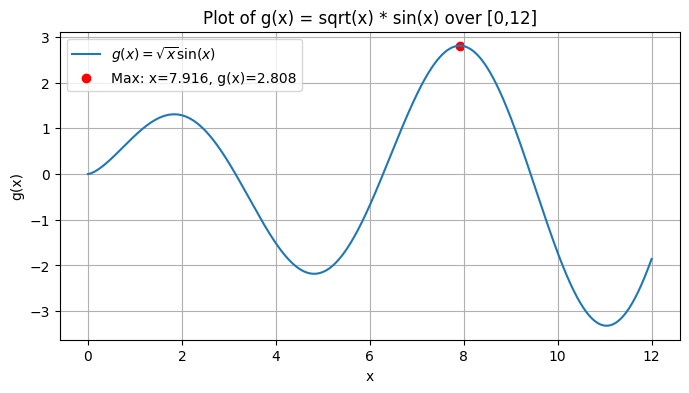

Maximum value of g(x) on [0,12]: 2.8081 at x = 7.9159


In [316]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the function
def g(x):
    return torch.sqrt(x) * torch.sin(x)

# Create a fine grid from 0 to 12
x = torch.linspace(0, 12, 1000)
y = g(x)

# Convert to numpy for plotting
x_np = x.numpy()
y_np = y.numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_np, y_np, label=r'$g(x) = \sqrt{x} \sin(x)$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('Plot of g(x) = sqrt(x) * sin(x) over [0,12]')
plt.grid(True)

# Find the maximum value and location
max_idx = torch.argmax(y)
max_x = x[max_idx].item()
max_y = y[max_idx].item()

# Mark the maximum on the plot
plt.scatter([max_x], [max_y], color='red', label=f'Max: x={max_x:.3f}, g(x)={max_y:.3f}')
plt.legend()
plt.show()

print(f"Maximum value of g(x) on [0,12]: {max_y:.4f} at x = {max_x:.4f}")


In [317]:
import numpy as np
import torch
from pyDOE3 import lhs

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.optim import optimize_acqf

from gpytorch import kernels, means, likelihoods
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from gpytorch.priors import SmoothedBoxPrior, GammaPrior

In [318]:
seed = 42 #this keeps the lhs consistent
initial_sample = 16
nu=2.5
batch_size = initial_sample

iterations = 100

lengthscale_prior = GammaPrior(2.0, 4.0) # mean around 0.5, variance around 0.35
# beta = 2 */ torch.log(torch.tensor(t+1.0)).sqrt() # apparently theoretically grounded in Srinivas et al 2010

#since these are noiseless I adjust the model here from og 
fixed_noise = True   # turn this to False for learning noise; True for noiseless (still creates small nosie)

noise_level = 1e-2 # keep a super small noise to check the model can learn noise while testing
# noise boudarys for the likelihood (Gaussian) model in standard deviations. 
# even though this test is noiseless, we keep these here to test the noise learning gp model
lower_noise_bound = 1e-4**2
upper_noise_bound = 1e-2**2

In [319]:
dimensions = 50

bounds = torch.tensor([
    [0.0]* dimensions,  # Lower bounds
    [12.0]* dimensions   # Upper bounds 
], dtype=torch.double)


for i in range(dimensions):
    np.sqrt(i)*np.sin(i)

print(bounds.shape)


torch.Size([2, 50])


In [320]:

# standard Latin hypercube using maximin criterion (converts to tensor) (all values between 0 and 1)
lhs_design = torch.tensor(
            lhs(n = dimensions, samples = initial_sample, criterion = 'maximin', random_state=seed), 
        dtype=torch.double
        )

# scales the lhs over arbitrary dimensions to the preset bounds for input into objective function
scaled_lhs_design = bounds[0] + (bounds[1]-bounds[0])*lhs_design


In [321]:
scaled_lhs_design.shape
print(scaled_lhs_design)

tensor([[ 3.6760, 10.6692,  7.7095, 10.8463, 11.3934,  9.4329,  5.9859,  0.7059,
          6.3595, 11.3873,  3.4226,  0.9154, 11.0852,  8.3213,  3.9715, 11.6588,
          9.4932,  4.4383,  6.8504,  5.1791,  6.3796,  8.1016, 10.3016,  3.8342,
          2.4331,  6.9926,  0.7720,  5.5357, 11.4121,  0.7105,  8.0879,  8.9838,
         10.6173, 11.4679,  8.3854,  3.9417,  5.8397,  5.6809,  1.6733, 11.6229,
          4.3571,  8.3310,  5.2466,  3.2851,  2.4665,  1.0598,  8.3630,  3.1247,
          8.5601,  7.4571],
        [ 4.7342,  5.5571,  9.0794,  9.1137,  2.4407,  5.4756,  4.5438,  4.6063,
          4.7059,  6.2353, 11.2665,  5.2650,  3.4114,  3.4474,  1.3803,  9.6599,
          3.8889,  6.9364,  4.7529,  1.2216,  5.7064, 11.6616,  1.1286,  8.9943,
          1.1355,  1.1910,  6.7023,  4.1952,  0.7014,  6.7985,  2.9390,  7.7661,
         10.1221,  1.9186,  5.9050, 10.4933,  2.5114, 10.3050,  7.8860,  6.5657,
          4.7839,  9.1034,  9.4973,  9.0014, 10.5960,  7.6916,  0.4618,  0.2468,


In [322]:
def objective_function(X):
    """
    X: Tensore of shape (n_samples, dim)
    Returns: Tensor of shape (n_samples, 1)
    """

    y = torch.sqrt(X) * torch.sin(X) # shape (n_samples, dim)
    y_sum= y.sum(dim=1)

    return y_sum.unsqueeze(-1)

In [323]:
train_X = scaled_lhs_design
train_Y = objective_function(train_X)

print(train_Y)
train_Y.shape

tensor([[-17.0696],
        [-13.6146],
        [ 10.0554],
        [-35.4170],
        [ -4.2426],
        [ -7.7824],
        [ 15.1219],
        [ -1.5651],
        [ -9.9039],
        [-20.3209],
        [-25.6451],
        [ 21.0420],
        [ -6.2996],
        [ -9.3738],
        [-23.9458],
        [-39.7391]], dtype=torch.float64)


torch.Size([16, 1])

In [324]:
# Gaussian Process Model

# Only for further GP Model development

# Setup (Assume train_X, train_Y, bounds, and objective_function are defined)
# ===========================



# GP Model definition
class GPModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, fixed_noise, noise_level=noise_level,
                 lengthscale_prior=None, outputscale_prior=None,
                 lengthscale_constraint = None, outputscale_constraint=None):

        if fixed_noise:
            print(f"Training with FIXED noise: {noise_level} = std dev.")
            noise_variance = (noise_level * train_Y.mean()).pow(2)
            train_Yvar = torch.full_like(train_Y, noise_variance)
            likelihood = None
            super().__init__(
                train_X, train_Y, train_Yvar=train_Yvar, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dimensions)
            )
        else:
            print("Training with LEARNABLE noise (Gaussian Likelihood).")
            likelihood = likelihoods.GaussianLikelihood()
            super().__init__(
                train_X, train_Y, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dimensions)
            )
            lower_noise = lower_noise_bound**2  # lower noise bound
            upper_noise = upper_noise_bound**2  # upper noise bound

            # Add a **prior** (softly nudges during training)
            
            self.likelihood.noise_covar.register_prior(
                "noise_prior",
                SmoothedBoxPrior(lower_noise, upper_noise),
                "raw_noise"
            )
            
            # Add a **constraint** (hard bounding box)
            self.likelihood.noise_covar.register_constraint(
                "raw_noise",
                Interval(lower_noise, upper_noise)
            )
            

        self.mean_module = means.ConstantMean()#ZeroMean() # this is default ConstantMean() in GPyTorch. Worth investigating

        matern_kernel = kernels.MaternKernel(
            nu=nu,
            ard_num_dims=dimensions,
            lengthscale_prior=lengthscale_prior,
            lengthscale_constraint=lengthscale_constraint,
        )

        self.covar_module = kernels.ScaleKernel(
            base_kernel=matern_kernel,
            outputscale_prior=outputscale_prior,
            outputscale_constraint=outputscale_constraint,
        )
        
        
        
# the above is preset, and doesn't require much changing unless adding other features

# the below is the training function, whatever input into this will feed through the model above 
# (I.e., set lengthscale_prior here, and it will filter in above)
        
# Training function
def train_GP_model(train_X, train_Y, fixed_noise, noise_level=noise_level,
                   lengthscale_prior=lengthscale_prior, outputscale_prior=None,
                   lengthscale_constraint = None, outputscale_constraint=None): 
    model = GPModel(
        train_X, train_Y,
        fixed_noise=fixed_noise,
        noise_level=noise_level,
        lengthscale_prior=lengthscale_prior,
        outputscale_prior=outputscale_prior,
        lengthscale_constraint = lengthscale_constraint, 
        outputscale_constraint=outputscale_constraint
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    #===== Fit the model =====#
    fit_gpytorch_mll(mll) # This is the default (turn off the custom training loop below if using this)

    # to use a custom optimizer and make this model fully customizable you can use the bit below 
    # make sure to turn off the fit_gpytorch_mll above
    '''
    # Custom training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    model.train()
    mll.train()
    training_iter = 50
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, train_Y.squeeze(-1))
        loss.backward()
        optimizer.step()
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")
    #===== End of custom training loop =====#
    '''
    return model, mll


In [325]:
# BO Loop
# ===========================
# The learning stacks, so you can repeat this loop to get better results.


normalized_bounds = torch.stack([torch.zeros(bounds.shape[1], dtype=bounds.dtype), 
                                 torch.ones(bounds.shape[1], dtype=bounds.dtype)
                                ])
n_iterations = iterations # of BO LOOP 



num_restarts = 20 # restarts loop if it can't converge answer (also can improve answer by finding a better local optima)
raw_samples = 40 # total resamples taken for analysis
batch_size = batch_size # this is q THE REALWORLD # of EXPENSIVE EXPERIMENTS that your willing to do per BATCH

best_Ys = []

for iteration in range(n_iterations):
    print(f"\n=== Iteration {iteration + 1} ===")
    # Train model
    model, mll = train_GP_model(train_X, train_Y, 
                                #lengthscale_prior=lengthscale_prior, outputscale_prior=outputscale_prior, 
                                #lengthscale_constraint=lengthscale_constraint, outputscale_constraint=outputscale_constraint, 
                                fixed_noise)
    '''
    # Recompute batch_initial_conditions each iteration (important!)
    topk = torch.topk(train_Y.squeeze(), k=num_restarts, largest=True)
    batch_initial_conditions = X_normalized[topk.indices].unsqueeze(1)
    #best_f = model.outcome_transform(train_Y)[0].max().item() # best observed value so far (for EI)
    '''

    model.eval() #apparently this is good practice... though the model seemed to work fine without this
    model.likelihood.eval()
    # Acquisition function (try switching between UCB and qLogNEI to compare)
    
    
    #acq_func = qLogNoisyExpectedImprovement(model=model, X_baseline=train_X)
    beta = 2 / torch.log(torch.tensor(iteration+2.0)).sqrt()
    acq_func = qUpperConfidenceBound(model=model, beta=beta) # this is the UCB acquisition function

    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
    )

    # Evaluate objective
    new_y = objective_function(candidate)
    train_X = torch.cat([train_X, candidate], dim=0)


    train_Y = torch.cat([train_Y, new_y], dim=0)
    
    # some diagnostics
    print(train_Y.shape)
    best_idx = torch.argmax(train_Y.squeeze(-1))
    best_X = train_X[best_idx]
    best_Y = train_Y[best_idx].item()
    print(f"Best Y: {best_Y:.4f} at X: {best_X}")
    best_Ys.append(best_Y)

    print("Max predicted mean:", model.posterior(train_X).mean.max().item())



=== Iteration 1 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([32, 1])
Best Y: 21.0420 at X: tensor([ 8.9219, 10.1326,  6.1153,  0.3618,  8.3355,  8.0859,  8.9402,  6.4314,
         0.0543,  8.3675,  0.6619,  6.1044,  0.6184,  2.3718,  8.5320,  2.7981,
         2.3671,  8.3728, 10.3688,  2.4415,  2.7462,  9.5159, 10.5334,  7.5267,
         0.4461,  0.4625,  8.9095,  9.6245,  4.8318,  8.7271,  6.0002,  5.8690,
         8.8111,  0.3633,  7.1245,  1.0379,  6.8619,  1.5922,  4.3884,  6.9326,
         5.6259,  1.6685, 11.6586,  1.5664,  9.1338,  1.9385,  4.5666,  5.3560,
         1.8599,  2.0145], dtype=torch.float64)
Max predicted mean: 21.040633872666593

=== Iteration 2 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([48, 1])
Best Y: 21.0420 at X: tensor([ 8.9219, 10.1326,  6.1153,  0.3618,  8.3355,  8.0859,  8.9402,  6.4314,
         0.0543,  8.3675,  0.6619,  6.1044,  0.6184,  2.3718,  8.5320,  2.7981,
         2.3671,  8.3728, 10.3688,  2.4415,  2.7462,  9.5159,

c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\botorch\optim\fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


torch.Size([1200, 1])
Best Y: 89.2462 at X: tensor([7.6755, 1.5125, 1.8293, 8.4316, 2.9823, 7.8465, 4.2061, 7.5166, 7.7685,
        1.7307, 5.8169, 1.3317, 8.3911, 8.4045, 1.4364, 2.4461, 8.3262, 8.5925,
        6.6525, 8.0436, 8.1975, 7.6364, 7.6738, 7.5850, 2.2458, 7.9215, 1.5841,
        1.6115, 8.0519, 7.9511, 8.1125, 8.1089, 8.0837, 2.1151, 2.4243, 2.3953,
        8.1500, 8.5568, 8.0521, 5.3420, 8.1020, 1.8234, 8.0792, 2.3772, 2.0296,
        7.9449, 7.7633, 3.8070, 8.0329, 1.6445], dtype=torch.float64)
Max predicted mean: 86.97553304147247

=== Iteration 75 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([1216, 1])
Best Y: 90.8961 at X: tensor([7.5514, 1.3563, 2.1590, 8.3614, 2.6740, 7.7478, 4.2833, 7.5320, 7.7145,
        1.7329, 5.9236, 1.3496, 8.2532, 8.6739, 1.4466, 2.2837, 8.1674, 8.1620,
        6.6380, 7.9694, 8.2621, 7.5218, 7.7712, 7.9096, 2.2992, 7.9918, 1.4936,
        1.7151, 7.9547, 7.9614, 8.0897, 8.0713, 8.2224, 1.9317, 2.3527, 2.2177,
        8.1003, 8.4

c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1520, 1])
Best Y: 96.8348 at X: tensor([7.4311, 1.3830, 2.0358, 7.7744, 2.1576, 7.9495, 3.6860, 7.8954, 7.8645,
        1.9578, 7.0803, 1.4798, 7.5166, 7.9102, 1.5930, 1.9122, 7.7342, 7.7013,
        6.8629, 8.1966, 7.4002, 7.5938, 8.5586, 7.5925, 2.2784, 8.1992, 1.4162,
        2.1949, 7.9390, 8.2009, 8.2363, 7.8926, 7.8488, 2.4647, 1.9314, 2.1538,
        8.4142, 8.4561, 8.2831, 6.0857, 7.8759, 1.4238, 8.1105, 2.1483, 2.0198,
        7.9543, 8.2142, 3.5135, 8.2560, 1.7314], dtype=torch.float64)
Max predicted mean: 96.19307179075099

=== Iteration 95 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1536, 1])
Best Y: 96.8348 at X: tensor([7.4311, 1.3830, 2.0358, 7.7744, 2.1576, 7.9495, 3.6860, 7.8954, 7.8645,
        1.9578, 7.0803, 1.4798, 7.5166, 7.9102, 1.5930, 1.9122, 7.7342, 7.7013,
        6.8629, 8.1966, 7.4002, 7.5938, 8.5586, 7.5925, 2.2784, 8.1992, 1.4162,
        2.1949, 7.9390, 8.2009, 8.2363, 7.8926, 7.8488, 2.4647, 1.9314, 2.1538,
        8.4142, 8.4561, 8.2831, 6.0857, 7.8759, 1.4238, 8.1105, 2.1483, 2.0198,
        7.9543, 8.2142, 3.5135, 8.2560, 1.7314], dtype=torch.float64)
Max predicted mean: 96.83460904090252

=== Iteration 96 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1552, 1])
Best Y: 97.2897 at X: tensor([7.3854, 1.3471, 1.8449, 7.5136, 2.1629, 7.8767, 3.6829, 7.8691, 7.6158,
        1.8079, 6.9928, 1.4146, 7.7028, 7.9054, 1.6132, 2.0484, 7.6255, 7.7908,
        6.9023, 8.0970, 7.1615, 7.6847, 8.2591, 7.9114, 2.2153, 8.0030, 1.6010,
        2.1296, 7.9754, 8.2258, 8.0926, 7.9286, 7.7743, 2.4363, 2.0614, 2.2155,
        8.5297, 8.4055, 8.3061, 6.1260, 7.8036, 1.3412, 7.9836, 2.0897, 1.9720,
        8.0992, 8.1921, 3.3379, 8.2959, 1.8900], dtype=torch.float64)
Max predicted mean: 96.83455761941526

=== Iteration 97 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1568, 1])
Best Y: 97.2897 at X: tensor([7.3854, 1.3471, 1.8449, 7.5136, 2.1629, 7.8767, 3.6829, 7.8691, 7.6158,
        1.8079, 6.9928, 1.4146, 7.7028, 7.9054, 1.6132, 2.0484, 7.6255, 7.7908,
        6.9023, 8.0970, 7.1615, 7.6847, 8.2591, 7.9114, 2.2153, 8.0030, 1.6010,
        2.1296, 7.9754, 8.2258, 8.0926, 7.9286, 7.7743, 2.4363, 2.0614, 2.2155,
        8.5297, 8.4055, 8.3061, 6.1260, 7.8036, 1.3412, 7.9836, 2.0897, 1.9720,
        8.0992, 8.1921, 3.3379, 8.2959, 1.8900], dtype=torch.float64)
Max predicted mean: 97.28942893398455

=== Iteration 98 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1584, 1])
Best Y: 97.2897 at X: tensor([7.3854, 1.3471, 1.8449, 7.5136, 2.1629, 7.8767, 3.6829, 7.8691, 7.6158,
        1.8079, 6.9928, 1.4146, 7.7028, 7.9054, 1.6132, 2.0484, 7.6255, 7.7908,
        6.9023, 8.0970, 7.1615, 7.6847, 8.2591, 7.9114, 2.2153, 8.0030, 1.6010,
        2.1296, 7.9754, 8.2258, 8.0926, 7.9286, 7.7743, 2.4363, 2.0614, 2.2155,
        8.5297, 8.4055, 8.3061, 6.1260, 7.8036, 1.3412, 7.9836, 2.0897, 1.9720,
        8.0992, 8.1921, 3.3379, 8.2959, 1.8900], dtype=torch.float64)
Max predicted mean: 97.28936554979433

=== Iteration 99 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1600, 1])
Best Y: 97.2897 at X: tensor([7.3854, 1.3471, 1.8449, 7.5136, 2.1629, 7.8767, 3.6829, 7.8691, 7.6158,
        1.8079, 6.9928, 1.4146, 7.7028, 7.9054, 1.6132, 2.0484, 7.6255, 7.7908,
        6.9023, 8.0970, 7.1615, 7.6847, 8.2591, 7.9114, 2.2153, 8.0030, 1.6010,
        2.1296, 7.9754, 8.2258, 8.0926, 7.9286, 7.7743, 2.4363, 2.0614, 2.2155,
        8.5297, 8.4055, 8.3061, 6.1260, 7.8036, 1.3412, 7.9836, 2.0897, 1.9720,
        8.0992, 8.1921, 3.3379, 8.2959, 1.8900], dtype=torch.float64)
Max predicted mean: 97.28946026789012

=== Iteration 100 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([1616, 1])
Best Y: 97.2897 at X: tensor([7.3854, 1.3471, 1.8449, 7.5136, 2.1629, 7.8767, 3.6829, 7.8691, 7.6158,
        1.8079, 6.9928, 1.4146, 7.7028, 7.9054, 1.6132, 2.0484, 7.6255, 7.7908,
        6.9023, 8.0970, 7.1615, 7.6847, 8.2591, 7.9114, 2.2153, 8.0030, 1.6010,
        2.1296, 7.9754, 8.2258, 8.0926, 7.9286, 7.7743, 2.4363, 2.0614, 2.2155,
        8.5297, 8.4055, 8.3061, 6.1260, 7.8036, 1.3412, 7.9836, 2.0897, 1.9720,
        8.0992, 8.1921, 3.3379, 8.2959, 1.8900], dtype=torch.float64)
Max predicted mean: 97.30233211717476


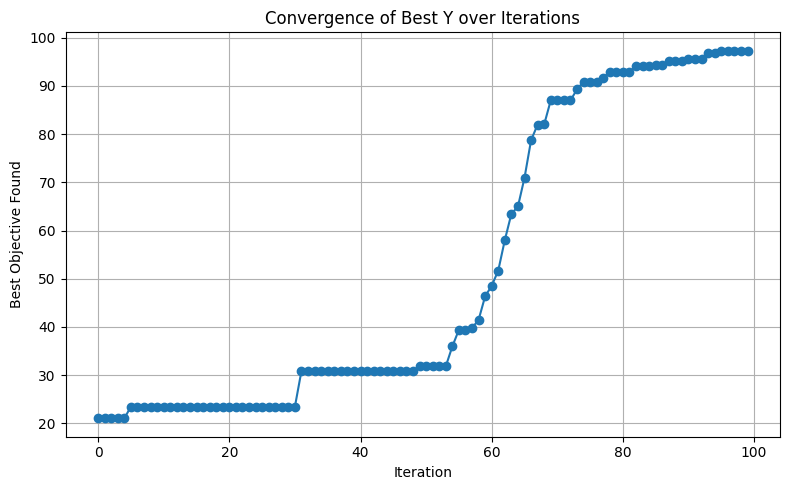

In [326]:
plt.figure(figsize=(8, 5))
plt.plot(best_Ys, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Objective Found")
plt.title("Convergence of Best Y over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()

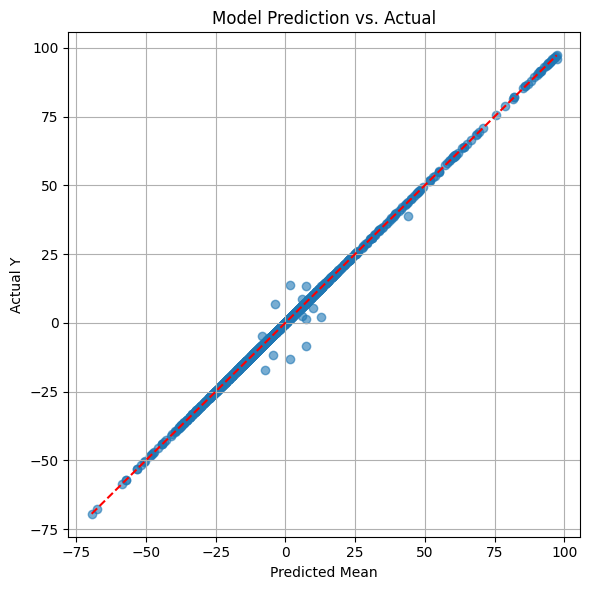

In [327]:
with torch.no_grad():
    posterior_mean = model.posterior(train_X).mean.squeeze(-1)

plt.figure(figsize=(6, 6))
plt.scatter(posterior_mean, train_Y.squeeze(-1), alpha=0.6)
plt.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'r--')
plt.xlabel("Predicted Mean")
plt.ylabel("Actual Y")
plt.title("Model Prediction vs. Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [328]:
# observed best
print(f"Best Y: {best_Y:.4f} at X: {best_X}")


# best model prediction
print("Max predicted mean:", model.posterior(train_X).mean.max().item())

print(f"Outputscale: {model.covar_module.outputscale.item():.6f}")
    
    
print(f"Lengthscale : {model.covar_module.base_kernel.lengthscale}")

Best Y: 97.2897 at X: tensor([7.3854, 1.3471, 1.8449, 7.5136, 2.1629, 7.8767, 3.6829, 7.8691, 7.6158,
        1.8079, 6.9928, 1.4146, 7.7028, 7.9054, 1.6132, 2.0484, 7.6255, 7.7908,
        6.9023, 8.0970, 7.1615, 7.6847, 8.2591, 7.9114, 2.2153, 8.0030, 1.6010,
        2.1296, 7.9754, 8.2258, 8.0926, 7.9286, 7.7743, 2.4363, 2.0614, 2.2155,
        8.5297, 8.4055, 8.3061, 6.1260, 7.8036, 1.3412, 7.9836, 2.0897, 1.9720,
        8.0992, 8.1921, 3.3379, 8.2959, 1.8900], dtype=torch.float64)
Max predicted mean: 97.30233211717476
Outputscale: 0.351725
Lengthscale : tensor([[0.7728, 0.7101, 0.7894, 1.0477, 0.8860, 0.8589, 0.7530, 0.4688, 0.9940,
         0.7300, 0.9953, 0.7949, 1.0026, 0.9612, 0.5596, 0.9991, 0.6209, 0.8683,
         1.0596, 0.6817, 0.9107, 0.8437, 0.9179, 0.9731, 0.8877, 0.8301, 0.7615,
         0.8921, 0.8645, 0.5495, 0.5531, 0.5851, 0.6617, 0.8340, 1.0370, 0.5006,
         0.9684, 0.7078, 0.7269, 0.9930, 0.7433, 0.8690, 0.5845, 0.8593, 0.7572,
         0.9473, 0.9979, 0.77

In [329]:
# this is the very approximate best answer 5pi/2 = 7.854, but actual best answers shoule be around 7.915

X = torch.full((1, dimensions), 5*np.pi/2, dtype=torch.double)

y = objective_function(X)

print(f"Objective function value at {X}: {y.item()}")


Objective function value at tensor([[7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540,
         7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540,
         7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540,
         7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540,
         7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540,
         7.8540, 7.8540, 7.8540, 7.8540, 7.8540]], dtype=torch.float64): 140.12478040994824
